In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.applications import MobileNetV2, NASNetMobile

## Dataset Preparation

In [2]:
df = pd.read_csv('./Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [3]:
#Label Encoding the categorical variable
label_encoder = LabelEncoder()
df['AQI_Class'] = label_encoder.fit_transform(df['AQI_Class'])
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,3
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,3
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,3
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,3
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,3


In [4]:
def getImageData(dirPath, filenames):
    images = []
    for filename in filenames:
        img = cv2.imread(dirPath+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype("float16") / 255.0
        images.append(img)
    return np.array(images)
    
location = "./Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/"
data = getImageData(location, df['Filename'].values.tolist())

In [5]:
X = data
y = df['AQI_Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [6]:
class_distribution = df['AQI_Class'].value_counts()

## Dataset Exploration

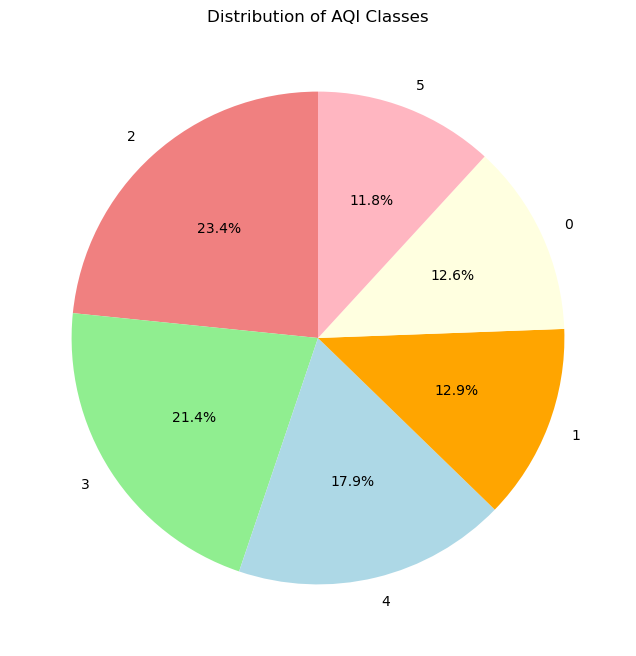

In [7]:
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen', 'lightblue', 'orange', 'lightyellow', 'lightpink'])
plt.title('Distribution of AQI Classes')
plt.show()

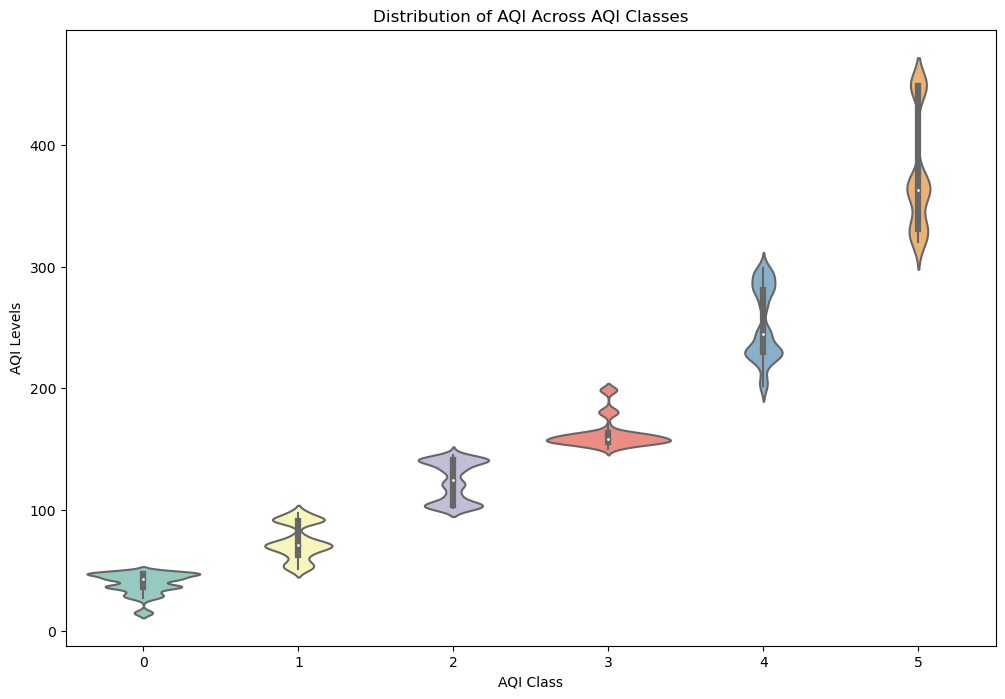

In [8]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='AQI_Class', y='AQI', data=df, palette='Set3')
plt.title('Distribution of AQI Across AQI Classes')
plt.xlabel('AQI Class')
plt.ylabel('AQI Levels')
plt.show()

## AQI Class Prediction

In [9]:
numberOfClasses = len(label_encoder.classes_)
y_train_encoded = to_categorical(y_train, num_classes=numberOfClasses)
y_test_encoded = to_categorical(y_test, num_classes=numberOfClasses)

### Using from scratch CNN model

In [10]:
cnnModel = Sequential()

cnnModel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnnModel.add(MaxPooling2D((2, 2)))
cnnModel.add(BatchNormalization())
cnnModel.add(Dropout(0.25))

cnnModel.add(Conv2D(64, (3, 3), activation='relu'))
cnnModel.add(MaxPooling2D((2, 2)))
cnnModel.add(BatchNormalization())
cnnModel.add(Dropout(0.25))

cnnModel.add(Conv2D(128, (3, 3), activation='relu'))
cnnModel.add(MaxPooling2D((2, 2)))
cnnModel.add(BatchNormalization())
cnnModel.add(Dropout(0.25))

cnnModel.add(Flatten())
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dropout(0.5))
cnnModel.add(Dense(numberOfClasses, activation='softmax'))  # Output layer with softmax for multi-class

In [11]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnnModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnnModel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        

In [12]:
history = cnnModel.fit(X_train, y_train_encoded, batch_size=64, epochs=50, validation_data=(X_test, y_test_encoded), verbose=1, callbacks=[earlyStopping])

Epoch 1/50


153/153 [==============================] - 138s 884ms/step - loss: 3.5366 - accuracy: 0.3069 - val_loss: 12.5064 - val_accuracy: 0.2198
Epoch 2/50
153/153 [==============================] - 132s 861ms/step - loss: 2.3232 - accuracy: 0.3327 - val_loss: 8.0324 - val_accuracy: 0.2275
Epoch 3/50
153/153 [==============================] - 136s 887ms/step - loss: 1.7730 - accuracy: 0.3256 - val_loss: 2.4681 - val_accuracy: 0.2945
Epoch 4/50
153/153 [==============================] - 145s 951ms/step - loss: 1.5447 - accuracy: 0.3506 - val_loss: 2.0326 - val_accuracy: 0.3574
Epoch 5/50
153/153 [==============================] - 140s 918ms/step - loss: 1.6394 - accuracy: 0.3537 - val_loss: 1.5738 - val_accuracy: 0.4383
Epoch 6/50
153/153 [==============================] - 142s 928ms/step - loss: 1.5070 - accuracy: 0.3576 - val_loss: 1.3955 - val_accuracy: 0.4400
Epoch 7/50
153/153 [==============================] - 142s 928ms/step - loss: 1.4133 - accuracy: 0.3840 - val_loss: 1.465

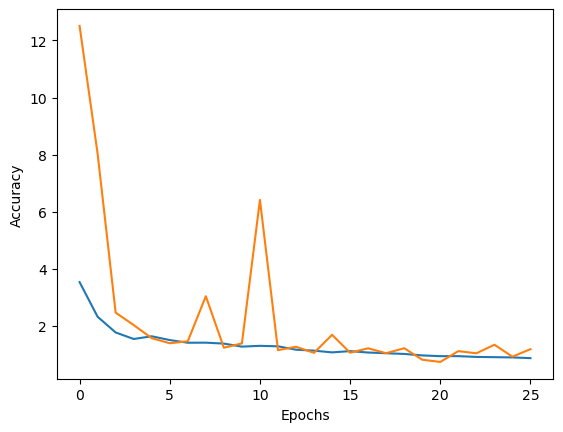

In [13]:
train_loss = history.history['loss']  
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [14]:
test_loss, test_acc = cnnModel.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_acc}')

77/77 [==============================] - 9s 118ms/step - loss: 0.7417 - accuracy: 0.6908
Test Accuracy: 0.6907680034637451


In [15]:
# Getting Predictions, their original encodings and their labels
predictions = cnnModel.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

predicted_labels = label_encoder.inverse_transform(predicted_labels)
true_labels = label_encoder.inverse_transform(y_test)
print(classification_report(true_labels, predicted_labels))

77/77 [==============================] - 10s 120ms/step
                                  precision    recall  f1-score   support

                          a_Good       0.44      0.85      0.58       294
                      b_Moderate       0.74      0.07      0.13       316
c_Unhealthy_for_Sensitive_Groups       0.59      0.74      0.66       583
                     d_Unhealthy       0.79      0.79      0.79       533
                e_Very_Unhealthy       0.95      0.76      0.85       442
                        f_Severe       0.97      0.81      0.88       280

                        accuracy                           0.69      2448
                       macro avg       0.75      0.67      0.65      2448
                    weighted avg       0.74      0.69      0.67      2448



### Using MobileNetV2 model

In [10]:
# Loading the transfer learning model
mvnBaseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the model's ;ayers
for layer in mvnBaseModel.layers:
    layer.trainable = False

mvnModel = Sequential()

# Adding few layers on top of it
mvnModel.add(mvnBaseModel)
mvnModel.add(GlobalAveragePooling2D())
mvnModel.add(Flatten())
mvnModel.add(Dense(128, activation='relu'))
mvnModel.add(BatchNormalization())
mvnModel.add(Dropout(0.5))
mvnModel.add(Dense(numberOfClasses, activation='softmax'))

In [11]:
mvnModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mvnModel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                       

In [12]:
history2 = mvnModel.fit(X_train, y_train_encoded, batch_size=64, epochs=50, validation_data=(X_test, y_test_encoded), verbose=1)

Epoch 1/50


153/153 [==============================] - 62s 379ms/step - loss: 0.9549 - accuracy: 0.6506 - val_loss: 0.5290 - val_accuracy: 0.8309
Epoch 2/50
153/153 [==============================] - 55s 360ms/step - loss: 0.5090 - accuracy: 0.8167 - val_loss: 0.3794 - val_accuracy: 0.8779
Epoch 3/50
153/153 [==============================] - 58s 382ms/step - loss: 0.3620 - accuracy: 0.8723 - val_loss: 0.2966 - val_accuracy: 0.8942
Epoch 4/50
153/153 [==============================] - 60s 392ms/step - loss: 0.2971 - accuracy: 0.8973 - val_loss: 0.2806 - val_accuracy: 0.9024
Epoch 5/50
153/153 [==============================] - 67s 436ms/step - loss: 0.2528 - accuracy: 0.9155 - val_loss: 0.2679 - val_accuracy: 0.9056
Epoch 6/50
153/153 [==============================] - 69s 451ms/step - loss: 0.2318 - accuracy: 0.9172 - val_loss: 0.2250 - val_accuracy: 0.9269
Epoch 7/50
153/153 [==============================] - 68s 444ms/step - loss: 0.1972 - accuracy: 0.9323 - val_loss: 0.2195 - val_

In [13]:
test_loss, test_acc = mvnModel.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_acc}')

77/77 [==============================] - 10s 131ms/step - loss: 0.1535 - accuracy: 0.9579
Test Accuracy: 0.9579248428344727


In [14]:
mvnPredictions = mvnModel.predict(X_test)
mvn_predicted_labels = np.argmax(mvnPredictions, axis=1)

mvn_predicted_labels = label_encoder.inverse_transform(mvn_predicted_labels)
true_labels = label_encoder.inverse_transform(y_test)

print(classification_report(true_labels, mvn_predicted_labels))

77/77 [==============================] - 13s 144ms/step
                                  precision    recall  f1-score   support

                          a_Good       0.99      0.90      0.94       294
                      b_Moderate       0.88      0.97      0.93       316
c_Unhealthy_for_Sensitive_Groups       0.96      0.93      0.95       583
                     d_Unhealthy       0.97      0.97      0.97       533
                e_Very_Unhealthy       0.96      0.98      0.97       442
                        f_Severe       0.98      0.99      0.99       280

                        accuracy                           0.96      2448
                       macro avg       0.96      0.96      0.96      2448
                    weighted avg       0.96      0.96      0.96      2448



### Using NASNetMobile

In [10]:
dnBaseModel = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in dnBaseModel.layers:
    layer.trainable = False

dnModel = Sequential()

dnModel.add(dnBaseModel)
dnModel.add(GlobalAveragePooling2D())
dnModel.add(Flatten())
dnModel.add(Dense(128, activation='relu'))
dnModel.add(BatchNormalization())
dnModel.add(Dropout(0.5))
dnModel.add(Dense(numberOfClasses, activation='softmax'))



19993432/19993432 [==============================] - 4s 0us/step


In [11]:
dnModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnModel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (  (None, 1056)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1056)              0         
                                                                 
 dense (Dense)               (None, 128)               135296    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               

In [12]:
history3 = dnModel.fit(X_train, y_train_encoded, batch_size=64, epochs=50, validation_data=(X_test, y_test_encoded), verbose=1)

Epoch 1/50


153/153 [==============================] - 105s 584ms/step - loss: 1.2029 - accuracy: 0.5718 - val_loss: 0.8174 - val_accuracy: 0.7083
Epoch 2/50
153/153 [==============================] - 91s 595ms/step - loss: 0.7057 - accuracy: 0.7340 - val_loss: 0.5844 - val_accuracy: 0.7900
Epoch 3/50
153/153 [==============================] - 81s 527ms/step - loss: 0.5661 - accuracy: 0.7897 - val_loss: 0.5166 - val_accuracy: 0.8027
Epoch 4/50
153/153 [==============================] - 68s 447ms/step - loss: 0.4863 - accuracy: 0.8183 - val_loss: 0.4408 - val_accuracy: 0.8476
Epoch 5/50
153/153 [==============================] - 71s 468ms/step - loss: 0.4326 - accuracy: 0.8392 - val_loss: 0.4035 - val_accuracy: 0.8554
Epoch 6/50
153/153 [==============================] - 74s 482ms/step - loss: 0.4060 - accuracy: 0.8503 - val_loss: 0.4090 - val_accuracy: 0.8444
Epoch 7/50
153/153 [==============================] - 77s 502ms/step - loss: 0.3609 - accuracy: 0.8688 - val_loss: 0.3497 - val

In [13]:
test_loss, test_acc = dnModel.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_acc}')

77/77 [==============================] - 14s 186ms/step - loss: 0.2633 - accuracy: 0.9212
Test Accuracy: 0.921160101890564


In [14]:
dnPredictions = dnModel.predict(X_test)
dn_predicted_labels = np.argmax(dnPredictions, axis=1)

dn_predicted_labels = label_encoder.inverse_transform(dn_predicted_labels)
true_labels = label_encoder.inverse_transform(y_test)

print(classification_report(true_labels, dn_predicted_labels))

77/77 [==============================] - 18s 180ms/step
                                  precision    recall  f1-score   support

                          a_Good       0.89      0.85      0.87       294
                      b_Moderate       0.90      0.86      0.88       316
c_Unhealthy_for_Sensitive_Groups       0.87      0.96      0.91       583
                     d_Unhealthy       0.95      0.91      0.93       533
                e_Very_Unhealthy       0.97      0.94      0.96       442
                        f_Severe       0.97      0.96      0.97       280

                        accuracy                           0.92      2448
                       macro avg       0.92      0.92      0.92      2448
                    weighted avg       0.92      0.92      0.92      2448

